# Deep Computer Vision Using Convolutional Neural Networks

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras

# Set RNG state
np.random.seed(42)
tf.random.set_seed(42)


def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

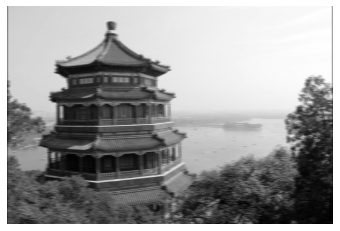

In [2]:
from sklearn.datasets import load_sample_image

max_intensity = 255

# Load sample images
china = load_sample_image("china.jpg") / max_intensity
flower = load_sample_image("flower.jpg") / max_intensity
images = np.array([china, flower])

batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

# Compute 2D convolution of two images and two filters (conv. kernels)
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

# Plot 1st image's 2nd feature map
plt.imshow(outputs[0, :, :, 1], cmap="gray")
plt.axis("off")
plt.show()

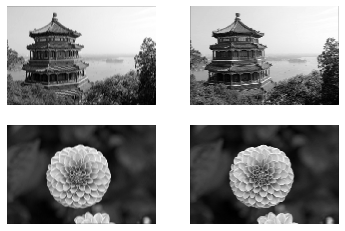

In [3]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

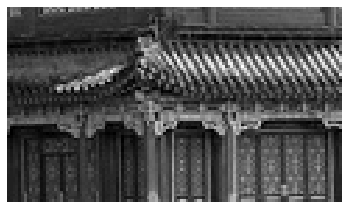

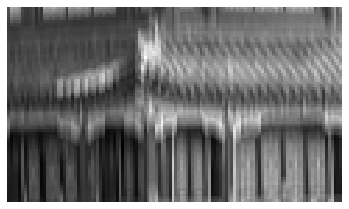

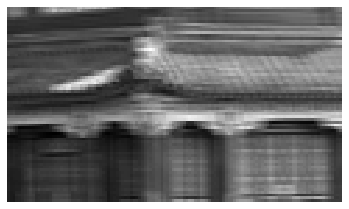

In [4]:
def crop(images):
    return images[150:220, 130:250]

# Plot cropped original images
plot_image(crop(images[0, :, :, 0]))
plt.show()

# Plot cropped feature maps
for feature_map_index in (0, 1):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

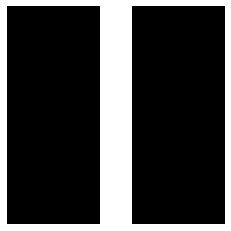

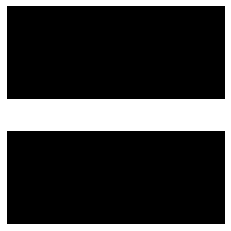

In [5]:
# Plot 1st filter
plot_image(filters[:, :, 0, 0])
plt.show()

# Plot 2nd filter
plot_image(filters[:, :, 0, 1])
plt.show()

## Convolutional Layer

Output of a neuron in a convolutional layer is at pixels $i, j$ in feature map $k$:
$z_{i,j,k} = b_k + \sum_{u = 0}^{f_h - 1} \sum_{v = 0}^{f_w - 1} \sum_{k' = 0}^{f_{n'} - 1} x_{i',j',k'} \times w_{u,v,k',k}$
where
* $f_h, f_w$ are the height and width of the *receptive field*, $f_{n'}$ is the number of feature maps in a conv. layer (no. conv. kernels or filters)
* $i' = i \times s_h + u$ and $j' = j \times s_w + v$ ($s_h$ and $s_w$ is are the vertical and horizontal *stride* hyper-parameters)
* $x_{i',j',k'}$ is the output of a neuron in previous (or input) layer at location $i', j'$ and in feature map $k'$
* $b_k$ is the bias term of feature map $k$ which tweaks the overall brightness of this feature map
* $w_{u,v,k',k}$ is the weight between a neuron in feature map $k$ and neuron in previous layer at respective location $u,v,k'$

*TensorFlow* typically represents an input image as a 3D tensor of shape *[height, width, channels]* and a micro-batch then is a 4D tensor with shape *[batch size, height, width, channels]*. The weights of a convolutional layer are also 4D tensors of shape $[f_h, f_w, f_{n'}, f_n]$.

In [6]:
# Build a 2D convolutional layer with 32 feature maps, kernels of size 3, no stride and ReLU activation
#  - `padding="SAME"` means that we add artificial 0 around the input to fill up the kernel at boarder locations
#  - `padding="VALID"` would skip some rows and/or coluns so that the kernel (filter) always points to valid image locations
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="SAME", activation="relu")

## Pooling layer

### Max pooling
*Max pooling* layer serves to subsample the inputs. It's similart to a conv. layer as it also contains a sliding kernel but contrary to convolutional layer it has no weights. So it is effectively a stateless transformation that reduces the number of parameters to train, adds some translational invariance and helps the model to focuse on the most intensive signals during training.

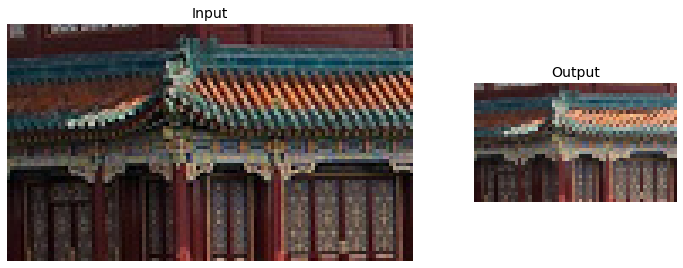

In [7]:
import matplotlib as mpl

# Crop each input image
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)

# Create and apply a max pooling layer with 2x2 kernel and stride 2
max_pool = keras.layers.MaxPool2D(pool_size=2)
output = max_pool(cropped_images)

# Plot the input and max pooling output of the 1st image
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

# Cropped input image
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")

# Max pooled output
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])
ax2.axis("off")

plt.show()

### Depth-wise pooling
It is also possible to pool not across the feature map dimension. This way one can make the model invariant to particular patterns, colors, transformations, etc. There is no TF/Keras high-level class but using a low-level API it's easy to implement.

In [8]:
class DepthMaxPool(keras.layers.Layer):
    
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    
    def call(self, inputs):
        # Apply the max pooling to depth
        #  - note that `pool_size` must be a multiple of the number of feature maps
        return tf.nn.max_pool(
            inputs,
            ksize=(1, 1, 1, self.pool_size),
            strides=(1, 1, 1, self.pool_size),
            padding=self.padding,
        )

# Test the depth max pooling on our cropped images
depth_pool = DepthMaxPool(3)

with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)

depth_output.shape

TensorShape([2, 70, 120, 1])

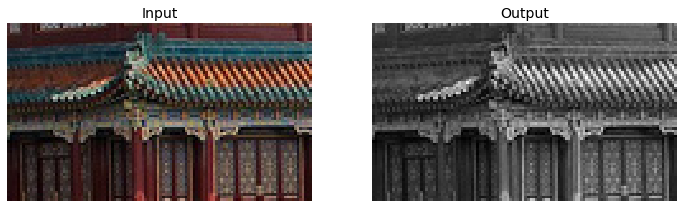

In [9]:
plt.figure(figsize=(12, 8))

# Plot the 1st image
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])

# Plot the output for the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])
plt.axis("off")

plt.show()

### Average pooling
Average pooling just uses different aggregation function (average instead of max) but otherwise it's pretty much the same.

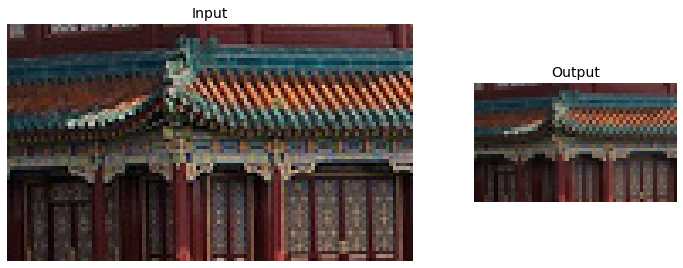

In [10]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_avg = avg_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])
ax2.axis("off")

plt.show()

### Global Average Pooling
Global average pooling is different in that it applies the average to the whole feature map. In other words, it's like using kernel of the same size as the input.

It's implementation is equivalent to this lambda:
```python
output_global_avg = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg(cropped_images)
```

In [11]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>

## CNN Architectures

Let's start with a generic CNN architecture (shown on the Fashion MNIST dataset).

In [12]:
from functools import partial

# Load and split the Fashion MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

val_split = 5000
X_train, X_valid = X_train_full[:-val_split], X_train_full[-val_split:]
y_train, y_valid = y_train_full[:-val_split], y_train_full[-val_split:]

# Normalize the inputs
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

# Reshape the inputs
X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Prepare default 2D convolutional layer
#  - It's better to use more convolutional layers with small kernels, like 3x3
#  - ReLU is quite standard activation function for CNNs
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

# Build a vanilla CNN classifier
#  - initial conv. kernel can be larger (7x7) because there's just few input channels
#  - subsequent conv. layer typically double the no. filters
#  - this is ok because it's evened up by the max pooling inbeteeen (which halves the no. parameters)
#  - there's very little spatial information left in the upper layers, therefore it's ok to flatten the inputs
#  - finally the upper part is typically few dense layers including some dropout
model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

# Train and validate the model for 10 epochs
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

# Evaluate the model on the test set
score = model.evaluate(X_test, y_test)

# Make new predicions (shown on few test images)
X_new = X_test[:10]
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 540s 314ms/step - loss: 0.7289 - accuracy: 0.7440 - val_loss: 0.3862 - val_accuracy: 0.8602
Epoch 2/10
1719/1719 [==============================] - 610s 355ms/step - loss: 0.4349 - accuracy: 0.8537 - val_loss: 0.3207 - val_accuracy: 0.8862
Epoch 3/10
1719/1719 [==============================] - 463s 269ms/step - loss: 0.3767 - accuracy: 0.8745 - val_loss: 0.3107 - val_accuracy: 0.8888
Epoch 4/10
1719/1719 [==============================] - 598s 348ms/step - loss: 0.3308 - accuracy: 0.8873 - val_loss: 0.3088 - val_accuracy: 0.8868
Epoch 5/10
1719/1719 [==============================] - 659s 383ms/step - loss: 0.3121 - accuracy: 0.8937 - val_loss: 0.2977 - val_accuracy: 0.8956
Epoch 6/10
1719/1719 [==============================] - 736s 428ms/step - loss: 0.2975 - accuracy: 0.8987 - val_loss: 0.3079 - val_accuracy: 0.9000
Epoch 7/10
1719/1719 [==============================] - 545s 317ms/step - loss: 0.2824 - accuracy: 0.9041 - val_

### ResNet-34

In [16]:
# Define base implementation of 2D convolutional layer
DefaultConv2D = partial(
    keras.layers.Conv2D,
    kernel_size=3,
    strides=1,
    padding="SAME",
    use_bias=False,
)

class ResidualUnit(keras.layers.Layer):
    """Module implementing single Residual Unit"""
    
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        # Main sequence of layers forming a residual unit
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()
        ]
        # If there's some non-trivial stride, add an extra conv. and BN layers
        #  - this serves to correct and align output shapes
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization(),
            ]
        else:
            self.skip_layers = []

    def call(self, inputs):
        # Pass the inputs through the main sequence of this unit
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
            
        # Add a skip connection connecting inputs and RU outputs
        #  - optionally adding the skip layers
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        
        # Sum outputs to learn `f(x) = h(x) - x`
        return self.activation(Z + skip_Z)

# Implement ResNet-34 architecture
model = keras.models.Sequential()

# Initial input processing layers
model.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))


# Counts of feature maps in consecutive RU layers
all_filters = (
    [64] * 3 + 
    [128] * 4 + 
    [256] * 6 + 
    [512] * 3
)
prev_filters = all_filters[0]

# Add a deep stack of Residual Units
for filters in all_filters:
    model.add(ResidualUnit(filters, strides=1 if filters == prev_filters else 2))
    prev_filters = filters

# Final layers that drop spatial information and add an output for a classification task
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

# Show the model structure
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
activation_3 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)       

## Using a Pretrained Model

102973440/102967424 [==============================] - 17s 0us/step


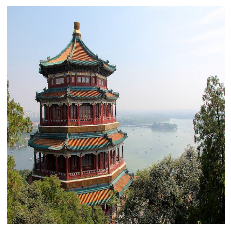

In [17]:
# Load pre-trained ResNet-50 for ImageNet
model = keras.applications.resnet50.ResNet50(weights="imagenet")

# Resize input images to ResNet-50 input shape
images_resized = tf.image.resize(images, [224, 224])

# Plot one of resized images
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


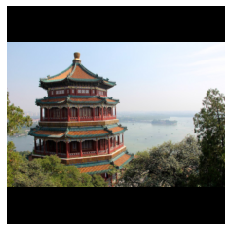

In [19]:
# Resize input images with padding to prevent the stretch
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])
plt.show()

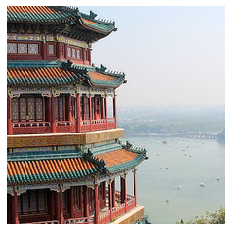

In [20]:
# Resize with crop or pad
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

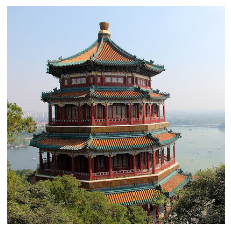

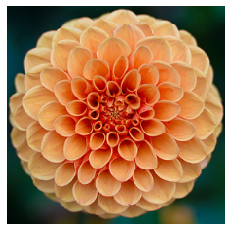

In [21]:
# Boxes for both input images
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]

# Crop and resize input images using pre-defined boxes
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])

# Show 1st input image
plot_color_image(images_resized[0])
plt.show()

# Show 2nd input image
plot_color_image(images_resized[1])
plt.show()

In [25]:
# Pre-process input images by the ResNet
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

# Make predicion on the inputs and return top-3 classes
Y_proba = model.predict(inputs)
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)

# Show the top-3 class predictions
for image_ix in range(len(images)):
    print(f"Image #{image_ix}")
    for class_id, name, y_proba in top_K[image_ix]:
        y_percent = y_proba * 100
        print(f"\t{class_id} - {name:12s} {y_percent:.2f}%")
    print()

Image #0
	n03877845 - palace       43.39%
	n02825657 - bell_cote    43.07%
	n03781244 - monastery    11.70%

Image #1
	n04522168 - vase         53.96%
	n07930864 - cup          9.52%
	n11939491 - daisy        4.97%

